In [64]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style
import json
from pprint import pprint


In [34]:
f = open('messages_w_time.json')
data = json.load(f)
data.keys()

dict_keys(['id', 'text', 'author'])

In [35]:
# create DF from data
train_data = pd.DataFrame.from_dict(data)
data_for_plot = pd.DataFrame.from_dict(data)

In [36]:
train_data

,id,text,author
0,897575377336148008,@everyone Just a quick reminder that our meeti...,UIUC GeoClub
1,897909470028529684,@everyone Just a reminder to that our Kickapoo...,UIUC GeoClub
2,901966694635954236,@everyone we are having some technical diffic...,UIUC GeoClub
3,935259795005509652,@everyone hi everyone! If you haven't heard al...,UIUC GeoClub
4,940631562272268329,@everyone Just a quick reminder that the first...,UIUC GeoClub
...,...,...,...
1941,971904632676818944,u guys good with going at 7 tomorrow? or 6? i’...,loanly
1942,972020510194036807,7 pm tomorrow,loanly
1943,974387641237778502,I got an astronomy test at 8 am tomorrow man,loanly
1944,974771470377037944,I'm just planning to leave before 3 PM tomorrow,loanly


In [13]:
document_lengths = np.array(list(map(len, train_data.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 72.58941418293936.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 774.


Fontconfig warning: ignoring UTF-8: not a valid region tag
/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


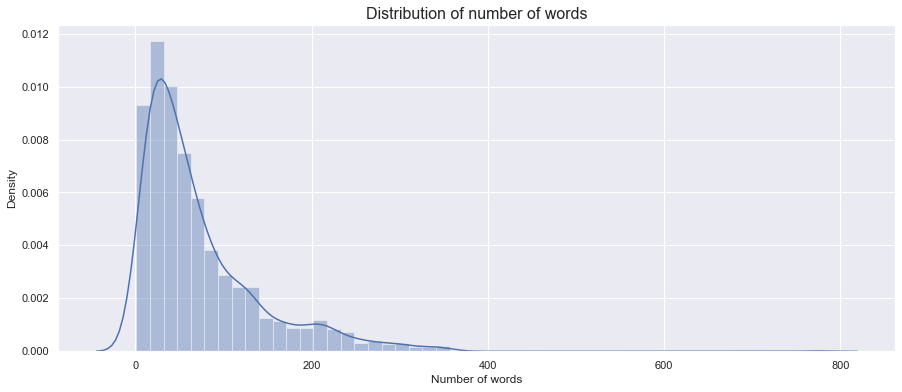

In [14]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [15]:
print("There are {} documents with over 300 words.".format(sum(document_lengths > 300)))

shorter_documents = document_lengths[document_lengths <= 300]

There are 23 documents with over 300 words.


/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


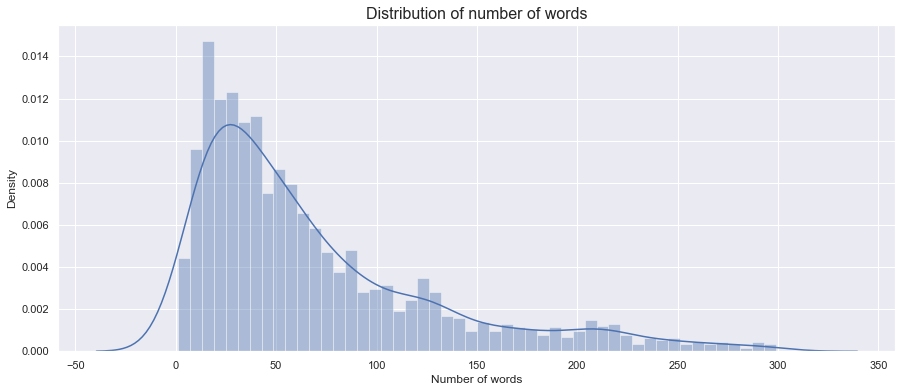

In [16]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [17]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))

There are 23 documents with tops 5 words.


In [18]:
train_data[document_lengths == 2]

,id,text,author
1917,898249016121393154,9:30 tonight?,loanly
1924,942551240544505957,4pm tomorrow,loanly


In [37]:
def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, "#")
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 1465 words with characters with an ordinal >= 128 in the train data.


In [38]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [39]:
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(train_data)

In [40]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_data)

In [41]:
tokenized_only_dict = Counter(np.concatenate(train_data.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [42]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


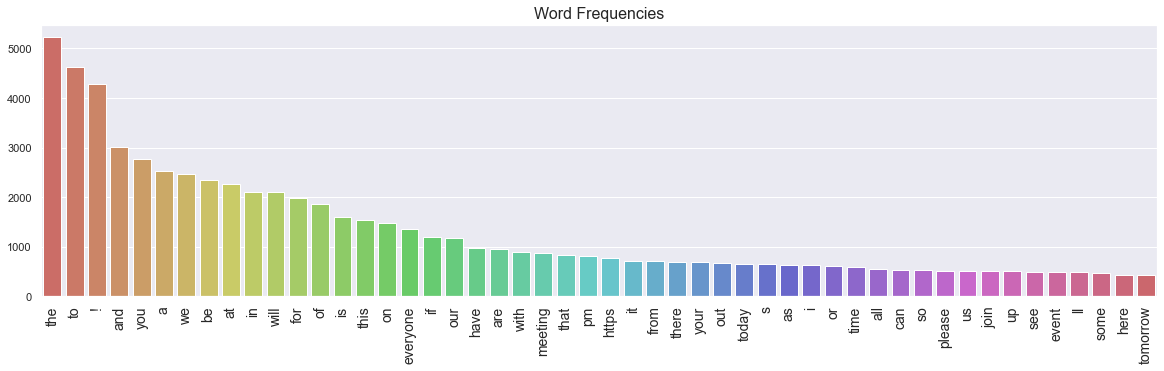

In [43]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiragrastogi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
# nltk.download('stopwords')
our_special_word = '#'
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_data)

In [48]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chiragrastogi/nltk_data...


True

In [49]:
# nltk.download('wordnet')
nltk.download('omw-1.4')
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_data)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chiragrastogi/nltk_data...


In [50]:
dictionary = Dictionary(documents=train_data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7153 words.


In [51]:
dictionary.filter_extremes(no_above=0.8, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 3806 words.


In [52]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train_data)

In [ ]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [54]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [56]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


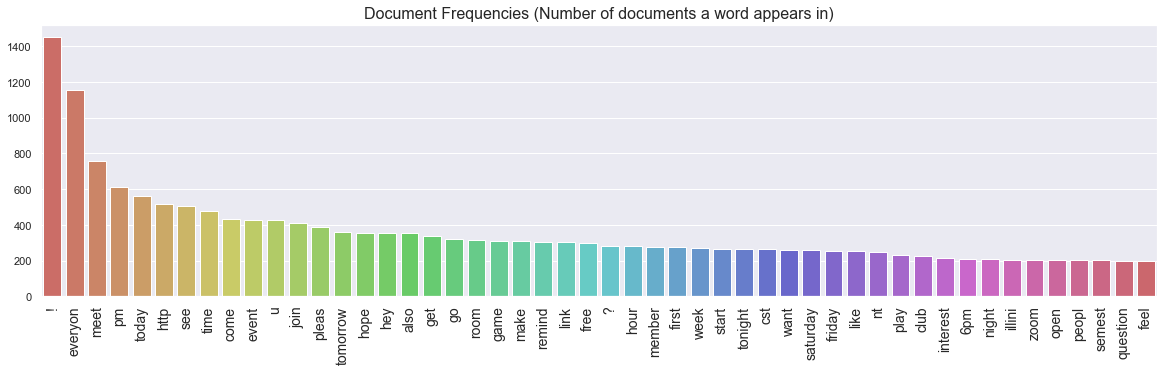

In [57]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [53]:
train_data

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,897575377336148008,@everyone just a quick reminder that our meeti...,UIUC GeoClub,[@everyone just a quick reminder that our meet...,"[[everyone, just, a, quick, reminder, that, ou...","[everyone, just, a, quick, reminder, that, our...","[everyone, quick, reminder, meeting, today, 53...","[everyone, quick, reminder, meeting, today, 53...","[everyon, quick, remind, meet, today, 530pm, c...","[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1..."
1,897909470028529684,@everyone just a reminder to that our kickapoo...,UIUC GeoClub,[@everyone just a reminder to that our kickapo...,"[[everyone, just, a, reminder, to, that, our, ...","[everyone, just, a, reminder, to, that, our, k...","[everyone, reminder, kickapoo, hiking, trip, s...","[everyone, reminder, kickapoo, hiking, trip, s...","[everyon, remind, kickapoo, hike, trip, saturd...","[(0, 2), (6, 1), (14, 1), (20, 1), (21, 1), (2..."
2,901966694635954236,@everyone we are having some technical diffic...,UIUC GeoClub,[@everyone we are having some technical diffi...,"[[everyone, we, are, having, some, technical, ...","[everyone, we, are, having, some, technical, d...","[everyone, technical, difficulties, geoclub, e...","[everyone, technical, difficulty, geoclub, ema...","[everyon, technic, difficulti, geoclub, email,...","[(0, 15), (2, 1), (6, 1), (10, 1), (11, 1), (2..."
3,935259795005509652,@everyone hi everyone! if you haven't heard al...,UIUC GeoClub,[@everyone hi everyone! if you haven't heard a...,"[[everyone, hi, everyone, !, if, you, have, nt...","[everyone, hi, everyone, !, if, you, have, nt,...","[everyone, hi, everyone, !, nt, heard, already...","[everyone, hi, everyone, !, nt, heard, already...","[everyon, hi, everyon, !, nt, heard, alreadi, ...","[(0, 3), (3, 1), (6, 2), (18, 1), (29, 1), (66..."
4,940631562272268329,@everyone just a quick reminder that the first...,UIUC GeoClub,[@everyone just a quick reminder that the firs...,"[[everyone, just, a, quick, reminder, that, th...","[everyone, just, a, quick, reminder, that, the...","[everyone, quick, reminder, first, meeting, ge...","[everyone, quick, reminder, first, meeting, ge...","[everyon, quick, remind, first, meet, geoclub,...","[(0, 1), (4, 1), (6, 1), (10, 1), (13, 1), (14..."
...,...,...,...,...,...,...,...,...,...,...
1941,971904632676818944,u guys good with going at 7 tomorrow? or 6? # ...,loanly,[u guys good with going at 7 tomorrow? or 6? #...,"[[u, guys, good, with, going, at, 7, tomorrow,...","[u, guys, good, with, going, at, 7, tomorrow, ...","[u, guys, good, going, 7, tomorrow, ?, 6, ?, f...","[u, guy, good, going, 7, tomorrow, ?, 6, ?, fl...","[u, guy, good, go, 7, tomorrow, ?, 6, ?, flexi...","[(81, 1), (84, 1), (96, 1), (120, 1), (143, 1)..."
1942,972020510194036807,7 pm tomorrow,loanly,[7 pm tomorrow],"[[7, pm, tomorrow]]","[7, pm, tomorrow]","[7, pm, tomorrow]","[7, pm, tomorrow]","[7, pm, tomorrow]","[(104, 1), (159, 1), (196, 1)]"
1943,974387641237778502,i got an astronomy test at 8 am tomorrow man,loanly,[i got an astronomy test at 8 am tomorrow man],"[[i, got, an, astronomy, test, at, 8, am, tomo...","[i, got, an, astronomy, test, at, 8, am, tomor...","[got, astronomy, test, 8, tomorrow, man]","[got, astronomy, test, 8, tomorrow, man]","[got, astronomi, test, 8, tomorrow, man]","[(196, 1), (320, 1), (343, 1), (354, 1), (468,..."
1944,974771470377037944,i'm just planning to leave before 3 pm tomorrow,loanly,[i'm just planning to leave before 3 pm tomorrow],"[[i, m, just, planning, to, leave, before, 3, ...","[i, m, just, planning, to, leave, before, 3, p...","[planning, leave, 3, pm, tomorrow]","[planning, leave, 3, pm, tomorrow]","[plan, leav, 3, pm, tomorrow]","[(29, 1), (104, 1), (123, 1), (196, 1), (811, 1)]"


In [59]:
corpus = train_data.bow

In [60]:
corpus

0       [(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1...
1       [(0, 2), (6, 1), (14, 1), (20, 1), (21, 1), (2...
2       [(0, 15), (2, 1), (6, 1), (10, 1), (11, 1), (2...
3       [(0, 3), (3, 1), (6, 2), (18, 1), (29, 1), (66...
4       [(0, 1), (4, 1), (6, 1), (10, 1), (13, 1), (14...
                              ...                        
1941    [(81, 1), (84, 1), (96, 1), (120, 1), (143, 1)...
1942                       [(104, 1), (159, 1), (196, 1)]
1943    [(196, 1), (320, 1), (343, 1), (354, 1), (468,...
1944    [(29, 1), (104, 1), (123, 1), (196, 1), (811, 1)]
1945                      [(196, 1), (811, 1), (1441, 1)]
Name: bow, Length: 1946, dtype: object

In [61]:
%%time
num_topics = 10
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 4.47 s, sys: 384 ms, total: 4.85 s
Wall time: 10.5 s


In [62]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      train_data.bow))


In [63]:
train_data

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features
0,897575377336148008,@everyone just a quick reminder that our meeti...,UIUC GeoClub,[@everyone just a quick reminder that our meet...,"[[everyone, just, a, quick, reminder, that, ou...","[everyone, just, a, quick, reminder, that, our...","[everyone, quick, reminder, meeting, today, 53...","[everyone, quick, reminder, meeting, today, 53...","[everyon, quick, remind, meet, today, 530pm, c...","[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1...","[0.008018451742827892, 0.005981671158224344, 0..."
1,897909470028529684,@everyone just a reminder to that our kickapoo...,UIUC GeoClub,[@everyone just a reminder to that our kickapo...,"[[everyone, just, a, reminder, to, that, our, ...","[everyone, just, a, reminder, to, that, our, k...","[everyone, reminder, kickapoo, hiking, trip, s...","[everyone, reminder, kickapoo, hiking, trip, s...","[everyon, remind, kickapoo, hike, trip, saturd...","[(0, 2), (6, 1), (14, 1), (20, 1), (21, 1), (2...","[0.014812489971518517, 0.4245939552783966, 0.0..."
2,901966694635954236,@everyone we are having some technical diffic...,UIUC GeoClub,[@everyone we are having some technical diffi...,"[[everyone, we, are, having, some, technical, ...","[everyone, we, are, having, some, technical, d...","[everyone, technical, difficulties, geoclub, e...","[everyone, technical, difficulty, geoclub, ema...","[everyon, technic, difficulti, geoclub, email,...","[(0, 15), (2, 1), (6, 1), (10, 1), (11, 1), (2...","[0.0020475382916629314, 0.001538757118396461, ..."
3,935259795005509652,@everyone hi everyone! if you haven't heard al...,UIUC GeoClub,[@everyone hi everyone! if you haven't heard a...,"[[everyone, hi, everyone, !, if, you, have, nt...","[everyone, hi, everyone, !, if, you, have, nt,...","[everyone, hi, everyone, !, nt, heard, already...","[everyone, hi, everyone, !, nt, heard, already...","[everyon, hi, everyon, !, nt, heard, alreadi, ...","[(0, 3), (3, 1), (6, 2), (18, 1), (29, 1), (66...","[0.005794685333967209, 0.004317787010222673, 0..."
4,940631562272268329,@everyone just a quick reminder that the first...,UIUC GeoClub,[@everyone just a quick reminder that the firs...,"[[everyone, just, a, quick, reminder, that, th...","[everyone, just, a, quick, reminder, that, the...","[everyone, quick, reminder, first, meeting, ge...","[everyone, quick, reminder, first, meeting, ge...","[everyon, quick, remind, first, meet, geoclub,...","[(0, 1), (4, 1), (6, 1), (10, 1), (13, 1), (14...","[0.2011547088623047, 0.633321225643158, 0.0083..."
...,...,...,...,...,...,...,...,...,...,...,...
1941,971904632676818944,u guys good with going at 7 tomorrow? or 6? # ...,loanly,[u guys good with going at 7 tomorrow? or 6? #...,"[[u, guys, good, with, going, at, 7, tomorrow,...","[u, guys, good, with, going, at, 7, tomorrow, ...","[u, guys, good, going, 7, tomorrow, ?, 6, ?, f...","[u, guy, good, going, 7, tomorrow, ?, 6, ?, fl...","[u, guy, good, go, 7, tomorrow, ?, 6, ?, flexi...","[(81, 1), (84, 1), (96, 1), (120, 1), (143, 1)...","[0.01608503982424736, 0.30357199907302856, 0.0..."
1942,972020510194036807,7 pm tomorrow,loanly,[7 pm tomorrow],"[[7, pm, tomorrow]]","[7, pm, tomorrow]","[7, pm, tomorrow]","[7, pm, tomorrow]","[7, pm, tomorrow]","[(104, 1), (159, 1), (196, 1)]","[0.05161313712596893, 0.7878889441490173, 0.03..."
1943,974387641237778502,i got an astronomy test at 8 am tomorrow man,loanly,[i got an astronomy test at 8 am tomorrow man],"[[i, got, an, astronomy, test, at, 8, am, tomo...","[i, got, an, astronomy, test, at, 8, am, tomor...","[got, astronomy, test, 8, tomorrow, man]","[got, astronomy, test, 8, tomorrow, man]","[got, astronomi, test, 8, tomorrow, man]","[(196, 1), (320, 1), (343, 1), (354, 1), (468,...","[0.029411785304546356, 0.022291148081421852, 0..."
1944,974771470377037944,i'm just planning to leave before 3 pm tomorrow,loanly,[i'm just planning to leave before 3 pm tomorrow

In [66]:
# Print the Keyword in the 10 topics
pprint(LDAmodel.print_topics())
doc_lda = LDAmodel[corpus]

[(0,
  '0.060*"!" + 0.021*"acm" + 0.020*"cst" + 0.019*"everyon" + 0.017*"today" + '
  '0.014*"night" + 0.014*"join" + 0.014*"hour" + 0.011*"http" + 0.011*"pm"'),
 (1,
  '0.043*"!" + 0.040*"meet" + 0.035*"everyon" + 0.029*"tonight" + 0.018*"pm" + '
  '0.017*"6pm" + 0.016*"today" + 0.016*"remind" + 0.012*"time" + '
  '0.012*"tomorrow"'),
 (2,
  '0.032*"!" + 0.017*"event" + 0.013*"everyon" + 0.011*"start" + 0.010*"join" '
  '+ 0.009*"make" + 0.008*"room" + 0.008*"come" + 0.008*"time" + 0.007*"get"'),
 (3,
  '0.046*"!" + 0.022*"game" + 0.020*"meet" + 0.018*"everyon" + 0.015*"club" + '
  '0.012*"pm" + 0.012*"time" + 0.011*"chess" + 0.011*"union" + 0.011*"illini"'),
 (4,
  '0.036*"!" + 0.019*"vr" + 0.011*"club" + 0.011*"everyon" + 0.011*"pm" + '
  '0.010*"u" + 0.010*"time" + 0.008*"http" + 0.008*"?" + 0.007*"today"'),
 (5,
  '0.053*"!" + 0.011*"http" + 0.009*"friday" + 0.009*"go" + 0.008*"free" + '
  '0.008*"everyon" + 0.008*"practic" + 0.008*"?" + 0.008*"hour" + '
  '0.007*"open"'),
 (6,
  

In [72]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

NameError: name 'id2word' is not defined